<a href="https://colab.research.google.com/github/SukritBagaria/Financial-sentiment-analysis/blob/main/Bert_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pre-trained model name

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

## Importing the requirements

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from collections import defaultdict
from textwrap import wrap

import pickle

from pydantic import BaseModel
from typing import Dict

from fastapi import FastAPI

from colabcode import ColabCode


%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
import os
os.chdir ("/drive/MyDrive/finance/")
!ls

all-data.csv  best_model_state.bin  model  model_gb.pkl  models.py  __pycache__


## Have a look at the data

In [ ]:
df = pd.read_csv("all-data.csv", names = ["label", "text"], encoding='latin-1')

In [ ]:
df.head()

,label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
df.shape

(4846, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4846 non-null   object
 1   text    4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


no null values are present

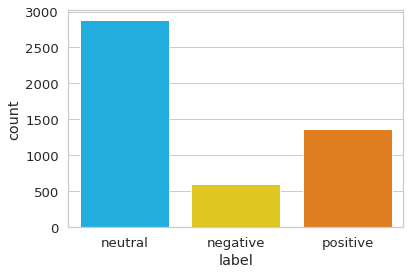

In [ ]:
sns.countplot(x = "label", data = df)

##Data Preprocessing

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])

In [ ]:
df.head()

,label,text
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

### Choosing Sequence Length

In [ ]:
token_lens = []

for txt in df['text']:
  tokens = tokenizer.encode(txt, max_length = 512, truncation = True)
  token_lens.append(len(tokens))

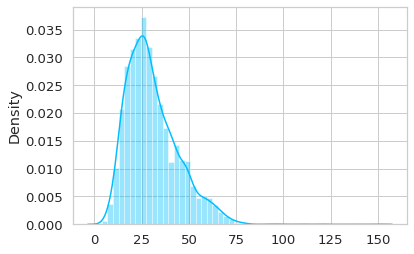

In [ ]:
sns.distplot(token_lens)

We can choose the maximum sequence length of 88, as length of all the sequences in our dataset are below 88

(the larger the sequences, the slower the model is going to train)

In [ ]:
MAX_LEN = 88
BATCH_SIZE = 8
EPOCHS = 3

### Building BERT Dataset

In [ ]:
class DataSet(Dataset):

  def __init__(self, text, label, tokenizer, max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(label, dtype=torch.long)
    }

### Splitting the data

In [ ]:
df_train, df_test = train_test_split(
  df,
  test_size=0.2,
  random_state=42
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=42
)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((3876, 2), (485, 2), (485, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):

  ds = DataSet(
    text = df.text.to_numpy(),
    label = df.label.to_numpy(),
    tokenizer = tokenizer,
    max_len = max_len
  )
  return DataLoader(
    ds,
    batch_size = batch_size,
    shuffle = True
  )

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
##example batch from training data loader

data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


dict_keys(['text', 'input_ids', 'attention_mask', 'label'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([8, 88])
torch.Size([8, 88])
torch.Size([8])


## Model Building

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Sentiment Classifier

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Optimizer and Loss Function

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

### Model Training

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    label = d["label"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, label)

    correct_predictions += torch.sum(preds == label)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

## Model Evaluation

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      label = d["label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, label)
      correct_predictions += torch.sum(preds == label)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

### Accuracy on training data and validation data

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.5506654015790249 accuracy 0.7889576883384932
Val   loss 0.3622364265019776 accuracy 0.8494845360824742

Epoch 2/3
----------
Train loss 0.2642201763745781 accuracy 0.9215686274509803
Val   loss 0.5830367827162024 accuracy 0.8391752577319588

Epoch 3/3
----------
Train loss 0.13416505673271364 accuracy 0.9625902992776058
Val   loss 0.5966993015122096 accuracy 0.8556701030927836

CPU times: user 4min 59s, sys: 16.2 s, total: 5min 15s
Wall time: 5min 23s


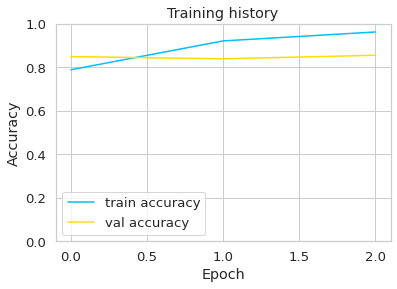

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='val accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.ylim([0, 1]);

### Accuracy on test data

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8597938144329897

### Get Predictions

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      label = d["label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(label)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return texts, predictions, prediction_probs, real_values

In [ ]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

### Classification Report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.86      0.88      0.87        56
     neutral       0.90      0.87      0.89       285
    positive       0.78      0.83      0.80       144

    accuracy                           0.86       485
   macro avg       0.85      0.86      0.85       485
weighted avg       0.86      0.86      0.86       485



### Confusion Matrix

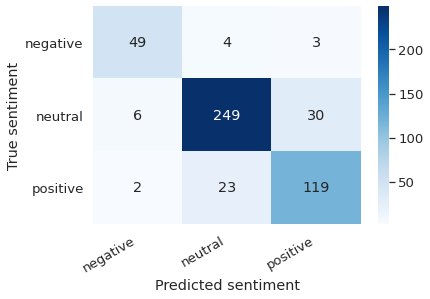

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")

  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Visualization of sentiment, confidence and probability

In [ ]:
idx = 6

text = y_texts[idx]
true_sentiment = y_test[idx]

print("\n".join(wrap(text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

The total value of the project is valued at SEK 30bn ( EUR 2.83 bn USD
3.81 bn ) .

True sentiment: neutral


In [ ]:
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

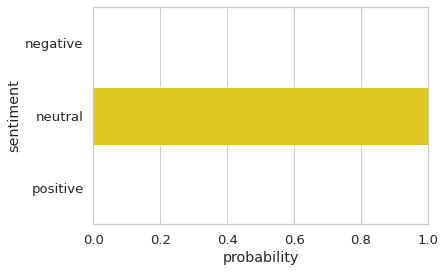

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

In [ ]:
df

,label,text
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...
...,...,...
4841,0,LONDON MarketWatch -- Share prices ended lower...
4842,1,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,0,Operating profit fell to EUR 35.4 mn from EUR ...
4844,0,Net sales of the Paper segment decreased to EU...


In [ ]:
text = df['text'][4841]

encoded_review = tokenizer.encode_plus(
  text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: LONDON MarketWatch -- Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .
Sentiment  : negative


##Saving the model

In [ ]:
# torch.save(model, '/drive/MyDrive/finance/model')

# saved_model = torch.load('/drive/MyDrive/finance/model')

In [ ]:
# pickle.dump(model, open("model_gb.pkl", "wb"))

## API Building

In [ ]:
class Model:
    def __init__(self):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        classifier = SentimentClassifier(3)
        classifier.load_state_dict(
            torch.load("/drive/MyDrive/finance/best_model_state.bin", map_location=self.device)
        )
        classifier = classifier.eval()
        self.classifier = classifier.to(self.device)
    def predict(self, text):
        encoded_text = self.tokenizer.encode_plus(
            text,
            max_length=MAX_LEN,
            add_special_tokens=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        input_ids = encoded_text["input_ids"].to(self.device)
        attention_mask = encoded_text["attention_mask"].to(self.device)
        with torch.no_grad():
            probabilities = F.softmax(self.classifier(input_ids, attention_mask), dim=1)
        confidence, predicted_class = torch.max(probabilities, dim=1)
        predicted_class = predicted_class.cpu().item()
        probabilities = probabilities.flatten().cpu().numpy().tolist()
        return (
            ["negative", "neutral", "positive"][predicted_class],
            confidence,
            dict(zip(["negative", "neutral", "positive"], probabilities)),
        )
yomodel = Model()
def get_model():
    return yomodel

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class SentimentRequest(BaseModel):
  text: str

class SentimentResponse(BaseModel):
  probabilities:Dict[str, float]
  sentiment: str
  confidence: float

In [ ]:
app = FastAPI()

@app.on_event("startup")
def load_model():
  global loaded_model
  loaded_model = get_model()

@app.get('/')
def index():
  return {'message': 'This is the homepage of the API'}

@app.post('/predict', response_model=SentimentResponse)
def predict(data: SentimentRequest):
  received = data.dict()
  text = received['text']
  sentiment, confidence, probabilities = loaded_model.predict(text)
  return SentimentResponse(
        sentiment=sentiment, confidence=confidence, probabilities=probabilities
    )

In [ ]:
server = ColabCode(port=10000, code = False)

In [ ]:
server.run_app(app = app)

Public URL: NgrokTunnel: "https://e860-35-192-220-243.ngrok.io" -> "http://localhost:10000"
